In [20]:
import os
import re

import numpy as np
from matplotlib import pyplot as plt
import keras
from keras.utils import pad_sequences, to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.text import Tokenizer

from models import LSTMModel

In [5]:
to_exclude = '!"#$%&()*+-/:;<=>@[\\]^_`{|}~\t'
to_tokenize = '.,:;!?\n'
tokenizer = Tokenizer(filters=to_exclude)

In [6]:
poem_dir = "data/poems/forms/ballad"
text = []
for file in sorted(os.listdir(poem_dir)):
    full_path = os.path.join(poem_dir, file)
    with open(full_path, encoding='utf-8-sig') as f:
        data = f.read()
    data = re.sub(r'(['+to_tokenize+'])', r' \1 ', data)
    text.append(data.lower())
print(text[0])

the burden of hard hitting .  slug away 
 like honus wagner or like tyrus cobb .  
 else fandom shouteth :  "who said you could play ?  
 back to the jasper league ,  you minor slob ! " 
 swat ,  hit ,  connect ,  line out ,  goet on the job .  
 else you shall feel the brunt of fandom's ire 
 biff ,  bang it ,  clout it ,  hit it on the knob - 
 this is the end of every fan's desire .  
 the burden of good pitching .  curved or straight .  
 or in or out ,  or haply up or down ,  
 to puzzle him that standeth by the plate ,  
 to lessen ,  so to speak ,  his bat-renown :  
 like christy mathewson or miner brown ,  
 so pitch that every man can but admire 
 and offer you the freedom of the town - 
 this is the end of every fan's desire .  
 the burden of loud cheering .  o the sounds !  
 the tumult and the shouting from the throats 
 of forty thousand at the polo grounds 
 sitting ,  ay ,  standing sans their hats and coats .  
 a mighty cheer that possibly denotes 
 that cub or pirat

In [8]:
tokenizer.fit_on_texts(text)
total_words = len(tokenizer.word_index) + 1
print(total_words)

8478


In [9]:
input_sequences = []
max_sequence_len = 20

for line in text:
    token_list = tokenizer.texts_to_sequences([line])[0]
    seq = []
    for i in range(1, len(token_list)):
        start_index = max(0, i - max_sequence_len + 1)
        end_index = i + 1
        n_gram_sequence = token_list[start_index:end_index]
        seq.append(n_gram_sequence)
    input_sequences.extend(seq)

max_sequence_len = max([len(line) for line in input_sequences])
pad_input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

print(input_sequences[10])
print(text[0].split(' ')[:10])

[3, 521, 6, 289, 4127, 5, 4128, 138, 1, 26, 4129, 4130]
['the', 'burden', 'of', 'hard', 'hitting', '.', '', 'slug', 'away', '\n']


In [10]:
X, labels = pad_input_sequences[:, :-1], pad_input_sequences[:, -1]
y = to_categorical(labels, num_classes=total_words)

In [11]:
model = LSTMModel().create(total_words=total_words, output_dim=2048, max_sequence_len=max_sequence_len)
model.model.summary()

Metal device set to: Apple M1 Pro


2022-12-08 23:18:26.547898: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-08 23:18:26.548172: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 19, 2048)          17362944  
                                                                 
 bidirectional (Bidirectiona  (None, 512)              4720640   
 l)                                                              
                                                                 
 dense (Dense)               (None, 8478)              4349214   
                                                                 
Total params: 26,432,798
Trainable params: 26,432,798
Non-trainable params: 0
_________________________________________________________________


In [12]:
class PredictionCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        seed = "All ours"
        next_words = 20

        for _ in range(next_words):
            token_list = tokenizer.texts_to_sequences([seed])[0]
            token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
            predicted = model.predict(token_list)[0]
            output_word = ""
            for word, index in tokenizer.word_index.items():
                if index == predicted:
                    output_word = word
                    break
            seed = " ".join([seed, output_word])
        print('\n', seed, '\n')

In [13]:
early_stopping = EarlyStopping(monitor="loss", patience=3)
model_checkpoint = ModelCheckpoint(
    filepath=model.MODEL_CHECKPOINT,
    save_weights_only=True,
    save_freq=5)

history = model.model.fit(
    X, y,
    epochs=10,
    batch_size=128,
    shuffle=True,
    callbacks=[model_checkpoint, early_stopping, PredictionCallback()]
)

Epoch 1/10


2022-12-08 23:18:33.281486: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-08 23:18:34.562489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-08 23:18:34.741725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-08 23:18:34.760648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/637 [..............................] - ETA: 18:54 - loss: 9.0456 - accuracy: 0.0000e+00

2022-12-08 23:18:34.902793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-08 23:18:34.920347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


637/637 [==============================] - ETA: 0s - loss: 5.8128 - accuracy: 0.1880

2022-12-08 23:21:11.334984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-08 23:21:11.389545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-08 23:21:11.398986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



 All ours , 
 and the little of the world , 
 and the little of the world , 
 and the 

637/637 [==============================] - 159s 247ms/step - loss: 5.8128 - accuracy: 0.1880
Epoch 2/10
637/637 [==============================] - ETA: 0s - loss: 4.8609 - accuracy: 0.2333
 All ours , 
 and the great stern was the world 
 and the great stern was the world . 
 and 

637/637 [==============================] - 155s 243ms/step - loss: 4.8609 - accuracy: 0.2333
Epoch 3/10
637/637 [==============================] - ETA: 0s - loss: 3.8608 - accuracy: 0.3006
 All ours , 
 and the moon is in the moon is , 
 and the moon swam is in the thing 

637/637 [==============================] - 159s 249ms/step - loss: 3.8608 - accuracy: 0.3006
Epoch 4/10
637/637 [==============================] - ETA: 0s - loss: 2.9600 - accuracy: 0.3994
 All ours 
 in the rolling plain , 
 where the rolling plain , 
 and the dockyard on him , 
 

637/637 [==============================] - 156s 245ms/step - loss: 2.9

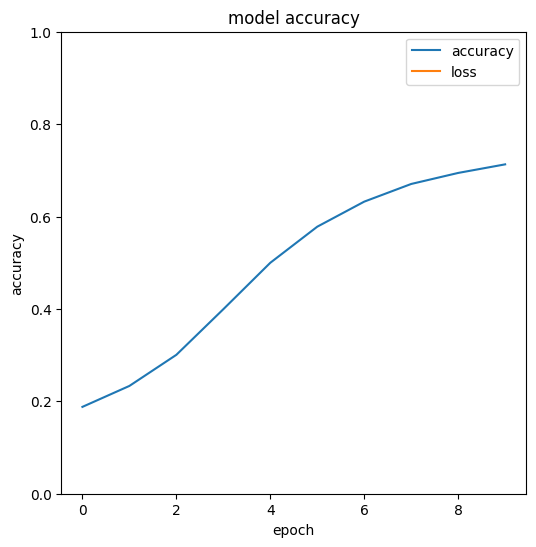

In [14]:
fig = plt.figure(figsize=(6, 6))
plt.plot(history.history['accuracy'], label="accuracy")
plt.plot(history.history['loss'], label="loss")
plt.ylim((0, 1))
plt.legend()
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()


In [15]:
model.save()

In [16]:
model = LSTMModel().load()

In [25]:
seed = "Let"
next_words = 100

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict(token_list)[0]
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed = " ".join([seed, output_word])
print(seed)

Let my son of gentleness , 
 and the wreath is beautiful , 
 with the wash of the world , 
 and hear with the floor , 
 that , chewing king alfred's ears . 
 and he stamped on the father of the happy town 
 that is with laughter , 
 that is the maid a stone to stray , 
 and all their remains that watches a rain that rules , 
 and burn of sweet a plough and weep 
 xxix . 
 to marienne god is bright with the head , 
 and the solemn
